In [1]:
import numpy as np
import pandas as pd

## Modelo LSTM

In [2]:
#Librerias para constuir el modelo LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [3]:
# cargar los datos de entrenamiento y test
X_train = pd.read_csv('https://raw.githubusercontent.com/KevinRamosRivas/G2-MINERIA_DATOS/main/X_train.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/KevinRamosRivas/G2-MINERIA_DATOS/main/X_test.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/KevinRamosRivas/G2-MINERIA_DATOS/main/y_train.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/KevinRamosRivas/G2-MINERIA_DATOS/main/y_test.csv')

In [4]:
# Retorna una lista de las metricas
def metrics(y_test_n, y_pred_n):
  from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, mean_absolute_error
  mse = mean_squared_error(y_test_n, y_pred_n)
  rms = mean_squared_error(y_test_n, y_pred_n, squared=False)
  mpd = mean_poisson_deviance(y_test_n, y_pred_n)
  mae = mean_absolute_error(y_test_n, y_pred_n)
  r2 = r2_score(y_test_n, y_pred_n)
  #print(f"RMSE: {rms} - MSE: {mse} - R2: {r2} - MPD: {mpd} - MAE: {mae}")
  return [rms, mse, r2, mae, mpd]

In [5]:
# Construccion del modelo de LSTM
def lstm_model(X_train_n, X_test_n, y_train_n, y_test_n):
  #reshape la entrada para que sea [muestras, pasos de tiempo, características]
  trainX, trainY = X_train_n.to_numpy(), y_train_n.to_numpy()
  testX, testY = X_test_n.to_numpy(), y_test_n.to_numpy()
  
  n_timesteps=1

  trainX = np.reshape(trainX, (trainX.shape[0], n_timesteps, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], n_timesteps, testX.shape[1]))
  
  n_features=trainX.shape[2]
  # definir el modelo
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
  model.add(Dense(1))
  # compilar el modelo
  model.compile(loss='mse', optimizer='adam', metrics =["MeanSquaredError"])
  # ajuste el modelo
  history = model.fit(trainX, trainY, epochs=50, batch_size=28, verbose=0)

  y_test_pred = model.predict(testX)
  
  return y_test_pred, history

In [6]:
# Aplicación del modelo para los clusteres de Kmedoids
def lstm_kmedoids(X_train, X_test, y_train, y_test):
  type_cluster = 'cluster_Kmedoids'
  # Lista del numero de clusteres existentes
  num_clusters = sorted(X_train[type_cluster].unique().tolist())
  # Tabla de metricas
  lstm_metrics = pd.DataFrame(columns=['RMSE', 'MSE', 'R2', 'MAE', 'MPD'], index=num_clusters)
  for i in num_clusters:
    # Seleccionamos los datos correspondientes al cluster i
    X_train_i, y_train_i  = X_train[X_train[type_cluster]==i], y_train[X_train[type_cluster]==i]
    X_test_i, y_test_i =  X_test[X_test[type_cluster]==i], y_test[X_test[type_cluster]==i]
    y_test_pred, hist = lstm_model(X_train_i.drop(columns=['cluster_Kmedoids','cluster_Kmeans']), 
                             X_test_i.drop(columns=['cluster_Kmedoids','cluster_Kmeans']),
                             y_train_i, y_test_i)
    # Guardamos las metricas segun el cluster / indice
    lstm_metrics.loc[i] = metrics(y_test_i.to_numpy(), y_test_pred)
  return lstm_metrics

In [7]:
# Aplicación del modelo para los clusteres de Kmeans
def lstm_kmeans(X_train, X_test, y_train, y_test):
  type_cluster = 'cluster_Kmeans'
  # Lista del numero de clusteres existentes
  num_clusters = sorted(X_train[type_cluster].unique().tolist())
  # Tabla de metricas
  lstm_metrics = pd.DataFrame(columns=['RMSE', 'MSE', 'R2', 'MAE', 'MPD'], index=num_clusters)
  for i in num_clusters:
    # Seleccionamos los datos correspondientes al cluster i
    X_train_i, y_train_i  = X_train[X_train[type_cluster]==i], y_train[X_train[type_cluster]==i]
    X_test_i, y_test_i =  X_test[X_test[type_cluster]==i], y_test[X_test[type_cluster]==i]
    y_test_pred, hist = lstm_model(X_train_i.drop(columns=['cluster_Kmedoids','cluster_Kmeans']), 
                             X_test_i.drop(columns=['cluster_Kmedoids','cluster_Kmeans']),
                             y_train_i, y_test_i)
    # Guardamos las metricas segun el cluster / indice
    lstm_metrics.loc[i] = metrics(y_test_i.to_numpy(), y_test_pred)
  return lstm_metrics

### Analizando sin usar clusters

In [8]:
# LSTM sin cluster
y_test_pred_kmedoids_sin, history = lstm_model(X_train.drop(columns=['cluster_Kmedoids','cluster_Kmeans']), 
                             X_test.drop(columns=['cluster_Kmedoids','cluster_Kmeans']),
                             y_train, y_test)
lstm_metrics_kmedoids_sin = pd.DataFrame(columns=['RMSE', 'MSE', 'R2', 'MAE', 'MPD'], index=['No Cluster'])
lstm_metrics_kmedoids_sin.loc['No Cluster'] = metrics(y_test.to_numpy(), y_test_pred_kmedoids_sin)
lstm_metrics_kmedoids_sin

5/5 [==============================] - 2s 9ms/step


,RMSE,MSE,R2,MAE,MPD
No Cluster,0.312946,0.097935,-0.019982,0.235644,0.021029


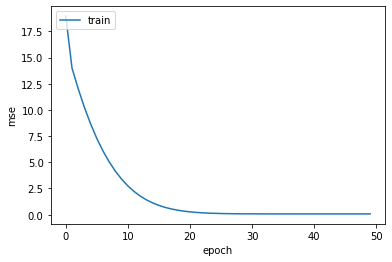

In [9]:
# plot metrics
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Analizando utilizando clustering con Kmedoids

In [10]:
lstm_kmedoids_metrics = lstm_kmedoids(X_train, X_test, y_train, y_test)
lstm_kmedoids_metrics

1/1 [==============================] - 1s 546ms/step


2/2 [==============================] - 1s 11ms/step


1/1 [==============================] - 1s 776ms/step


,RMSE,MSE,R2,MAE,MPD
0,1.934667,3.742938,-73.993433,1.921725,1.117399
1,1.925442,3.707328,-103.138421,1.916175,1.104922
2,3.563218,12.696523,-130.147609,3.549607,5.347938
3,1.807275,3.266242,-21.832381,1.767255,1.009076
4,0.820342,0.67296,-11.704854,0.787395,0.159418
5,2.09693,4.397117,-103.505945,2.086874,1.388491


### Analizando utilizando clustering con Kmeans

In [11]:
lstm_kmeans_metrics = lstm_kmeans(X_train, X_test, y_train, y_test)
lstm_kmeans_metrics

2/2 [==============================] - 1s 9ms/step


,RMSE,MSE,R2,MAE,MPD
0,4.33276,18.772806,-195.74283,4.321734,11.69331
1,0.998613,0.997229,-28.011607,0.981252,0.251112
2,0.361606,0.130759,-0.034068,0.282143,0.028881
3,0.64703,0.418648,-5.528172,0.597811,0.096788
